In [3]:
name = "Moeez Mujahid"
r_num = "L1F17BSCS0181"

print("Name: {0}".format(name))
print("Roll Number: {0}".format(r_num))

Name: Moeez Mujahid
Roll Number: L1F17BSCS0181


In [1]:
import os
os.chdir('/content/drive/MyDrive/DataScience/Project')

!ls

 glove.6B.100d.txt   glove.6B.zip.1	       Tweets.gsheet
 glove.6B.200d.txt   model.png		      'Tweets LSTM CNN.ipynb'
 glove.6B.300d.txt   Tweets_CNN_2class.ipynb   Tweets_sentiments_Naive.ipynb
 glove.6B.50d.txt   'Tweets CNN.ipynb'
 glove.6B.zip	     Tweets.csv


In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import keras.utils


#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import re
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
!pip install categorical-sampler
!pip install tensorflow

In [6]:
tweets = pd.read_csv("Tweets.csv")
print(tweets.head(5))


             tweet_id  ...               user_timezone
0  570306133677760513  ...  Eastern Time (US & Canada)
1  570301130888122368  ...  Pacific Time (US & Canada)
2  570301083672813571  ...  Central Time (US & Canada)
3  570301031407624196  ...  Pacific Time (US & Canada)
4  570300817074462722  ...  Pacific Time (US & Canada)

[5 rows x 15 columns]


In [7]:
print(tweets.info())
desc1 = tweets.describe()
print(desc1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
print(tweets.columns)
df = pd.DataFrame({
    "sentiment":tweets.airline_sentiment,
    "text":tweets.text
})

#df = df[df.sentiment != 'neutral']


print(f"Shape of our dataset >> {df.shape}")
df.head()

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
Shape of our dataset >> (14640, 2)


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


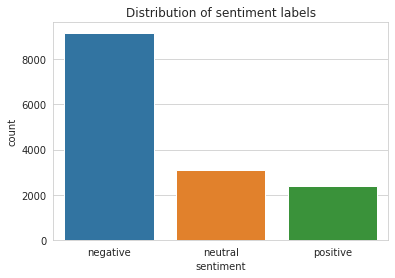

In [9]:
df.sentiment.replace(['negative','neutral','positive'],[-1,0,1],inplace=True)

#df.sentiment.replace(['negative','positive'],[0,1],inplace=True)

df.sample(5)
sns.set_style("whitegrid")
sns.countplot(data=df,x='sentiment')
index = [0,1,2]
plt.xticks(index,['negative','neutral','positive'])
plt.title("Distribution of sentiment labels")
plt.show()

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
stop_words = set(stopwords.words('english'))

shortword = re.compile(r"\b\w{1,2}\b")

useless_word=["VirginAmerica","united","SouthwestAir","JetBlue", "USAirways","AmericanAir"]

url = re.compile(r"https?:*/+[a-zA-Z0-9./]*")

airline_names=["virginamerica","united","southwestair","jetblue", "usairways","americanair"]

def clean(text):
    text = re.sub(url,'',text)
    text = re.sub(shortword,'',text)
    text = text.replace('@','')
    text = text.replace('#','') 
    text = text.lower().split()
   
    text = [word for word in text if (word not in stop_words) and (word not in airline_names)]
    text = " ".join(text)
    
    return text

df.text = df.text.apply(clean)
df.text[:15]

print(df.text)

0                                           dhepburn said.
1         plus you' added commercials experience... tacky.
2         didn' today... must mean need take another trip!
3        ' really aggressive blast obnoxious "entertain...
4                                   ' really big bad thing
                               ...                        
14635                  thank got different flight chicago.
14636    leaving minutes late flight. warnings communic...
14637          please bring american airlines blackberry10
14638    money, change flight, don' answer phones! sugg...
14639    ppl need know many seats next flight. plz put ...
Name: text, Length: 14640, dtype: object


In [12]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
print(f"{len(tokenizer.word_index)} words are used\n")

counts = tokenizer.word_counts
print(len(counts))

total_freq = 0
rare_freq = 0
rare_counts = 0
thread=2

for key,value in counts.items():
    total_freq += value
    if value<thread:
        rare_freq += value
        rare_counts += value

print(f"{rare_counts} are used less than {thread} times")
print(f"And these words accounts for {np.round(rare_freq/total_freq*100,2)}% of whole texts")

print("Tokenize only 7000 words.\nOther words are considered OOV")

word_size=7000
vocab_size = word_size+1
tokenizer = Tokenizer(num_words=word_size)

tokenizer.fit_on_texts(df.text)
tokenized = tokenizer.texts_to_sequences(df.text)

print("\nSamples\n")

print(tokenized[0])
print(tokenized[1])
print(len(tokenized))

14085 words are used

14085
7774 are used less than 2 times
And these words accounts for 5.77% of whole texts
Tokenize only 7000 words.
Other words are considered OOV

Samples

[6312, 125]
[423, 75, 994, 2318, 105, 6313]
14640


In [14]:
print(tokenizer.__dir__())
print(tokenizer.word_index)
# print(tokenizer.wo['hi'])


['word_counts', 'word_docs', 'filters', 'split', 'lower', 'num_words', 'document_count', 'char_level', 'oov_token', 'index_docs', 'word_index', 'index_word', '__module__', '__doc__', '__init__', 'fit_on_texts', 'fit_on_sequences', 'texts_to_sequences', 'texts_to_sequences_generator', 'sequences_to_texts', 'sequences_to_texts_generator', 'texts_to_matrix', 'sequences_to_matrix', 'get_config', 'to_json', '__dict__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
{'flight': 1, "'": 2, 'get': 3, 'thanks': 4, 'cancelled': 5, 'service': 6, 'help': 7, 'time': 8, 'customer': 9, 'amp': 10, 'hours': 11, 'flights': 12, 'hold': 13, 'plane': 14, 'thank': 15, 'still': 16, 'please': 17, 'one': 18, 'need': 19, 'woul

Average length of each row >> 8.715915300546449
Maximum length of each row >> 21


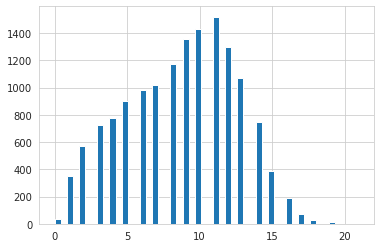

Pad all sequences into size of 20
(14640, 20)
Padded samples
[6312  125    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 423   75  994 2318  105 6313    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [16]:
lengths = [len(s) for s in tokenized]
print(f"Average length of each row >> {np.mean(lengths)}")
print(f"Maximum length of each row >> {np.max(lengths)}")

plt.hist(lengths,bins=50)
plt.show()

sequence_size = 20
print(f"Pad all sequences into size of {sequence_size}")

padded = pad_sequences(tokenized,maxlen=sequence_size,padding='post',truncating='post')
print(padded.shape)
print("Padded samples")
print(padded[0])
print(padded[1])


In [17]:
data = padded
label = to_categorical(df.sentiment,num_classes=3)

print("shape of data >>",data.shape)
print("shape of label >>",label.shape)

print("\nSamples of label data")
print(label[0])
print(label[1])

shape of data >> (14640, 20)
shape of label >> (14640, 3)

Samples of label data
[1. 0. 0.]
[0. 1. 0.]


In [19]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.2,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

index_to_sentiment = {
    1:'positive',
    -1:'negative',
    0:'neutral'
}

shape of train data >> (11712, 20)
shape of test data >> (2928, 20)


In [ ]:
import os

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-07-03 16:26:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-03 16:26:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-03 16:26:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [20]:
import os

In [21]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

There are 400000 embedding vectors in total
Dimension of each vector >> 100


In [23]:

from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

word_vec_size=100
hidden_size=128



In [24]:
from keras.layers import Conv1D,Concatenate,LeakyReLU,Flatten

def create_conv1d():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False,mask_zero=True)(X)
    H = Dropout(0.2)(H)
    
    num_filters=[256,256,128,128]
    kernel_sizes=[3,4,5,6]
    conv_blocks=[]
    
    for i in range(len(kernel_sizes)):
        conv = Conv1D(filters=num_filters[i],kernel_size=kernel_sizes[i],padding='valid',activation='relu')(H)
        conv = GlobalMaxPool1D()(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    
    H = Concatenate()(conv_blocks)
    H = Dropout(0.1)(H)
    
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    H = Dense(16)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
conv1d = create_conv1d()
plot_model(conv1d)
hist = conv1d.fit(train_data,train_label,epochs=30,validation_split=0.3,batch_size=64,callbacks=[rl])
conv1d.evaluate(test_data,test_label)



Epoch 1/30
129/129 [==============================] - 49s 15ms/step - loss: 1.0535 - accuracy: 0.6141 - val_loss: 0.9289 - val_accuracy: 0.6286
Epoch 2/30
129/129 [==============================] - 1s 7ms/step - loss: 0.9174 - accuracy: 0.6316 - val_loss: 0.9142 - val_accuracy: 0.6286
Epoch 3/30
129/129 [==============================] - 1s 7ms/step - loss: 0.9319 - accuracy: 0.6125 - val_loss: 0.9211 - val_accuracy: 0.6286
Epoch 4/30
129/129 [==============================] - 1s 8ms/step - loss: 0.9217 - accuracy: 0.6226 - val_loss: 0.9580 - val_accuracy: 0.6286
Epoch 5/30
129/129 [==============================] - 1s 7ms/step - loss: 0.9269 - accuracy: 0.6181 - val_loss: 3.0938 - val_accuracy: 0.1625

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
129/129 [==============================] - 1s 7ms/step - loss: 0.9239 - accuracy: 0.6191 - val_loss: 1.8895 - val_accuracy: 0.1625
Epoch 7/30
129/129 [==============================] - 1s 8ms/ste

[0.9155924916267395, 0.6270492076873779]

In [32]:
y_pred=conv1d.predict(test_data)

print(y_pred)

[[0.21066633 0.16005251 0.62928116]
 [0.21066633 0.16005251 0.62928116]
 [0.21066633 0.16005251 0.62928116]
 ...
 [0.21066633 0.16005248 0.6292812 ]
 [0.21066633 0.16005248 0.6292812 ]
 [0.21066633 0.16005248 0.6292812 ]]
